## ================= Libraries =================

#### Drive access

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Folder path

In [2]:
import os
os.chdir('/content/drive/MyDrive/Proyecto - Deep Learning')

### Libraries

In [3]:
# Data processing and numerical calculation.
import pandas as pd # Library for data manipulation and analysis.
import numpy as np # Library for numerical calculation in Python.
import copy # Module for copy objects in Python.
import random # Module for generating random numbers in Python.
import math # Module for mathematical functions in Python.

# Image processing.
import cv2 # Library for image processing and computer vision.
import matplotlib.pyplot as plt # Library for data visualization and graphics in Python.
import matplotlib.patches as patches # Module for drawing shapes and objects in graphics.

# Deep learning.
import torch # Library for deep learning in Python.
import torch.nn as nn # Module for neural networks in PyTorch.
import torchvision # Library that provides datasets, transformations, and pre-trained deep learning models for computer vision.
from torchvision import transforms, datasets # Torchvision-specific modules.
from torchvision.models.detection import * # Module for object detection.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Module for object detection.

# Data augmentations.
import albumentations # Library for data augmentation in computer vision.
from albumentations.pytorch.transforms import ToTensorV2 # Converts the augmented image data to a PyTorch tensor format.

# Auxiliary classes.
from image_dataset import ImageDataset # Dataset class.
from faster_RCNN import FasterRCNNModel # Model class.

# Auxiliary functions.
from engine import train_one_epoch, evaluate # Modules with functions for training and evaluating deep learning models.
import utils # Module with utility functions for deep learning.
from xml.etree import ElementTree as et # Module for parsing and manipulating XML documents.

# Hide warnings.
import warnings # Module for controlling warnings in Python.
warnings.filterwarnings('ignore') # Ignore command.

## <br><br><br><br><br> ================= Common functions =================

### Plot image with its bbox

In [4]:
def plot_img_with_bbox(img, target, title):
  # Size.
  plt.figure(figsize=(8,4))

  # Show image.
  plt.title(title, fontsize=12)
  plt.imshow(img)

  # Iterate for any box.
  for box in (target['boxes']):
    # Get origin point.
    x, y = box[0], box[1]

    # Get width and height of the bbox.
    width, height = box[2]-box[0], box[3]-box[1]

    # Get rectangle of the bbox.
    rect = patches.Rectangle((x, y),
                             width, height,
                             linewidth = 1,
                             edgecolor = 'b',
                             facecolor = 'none')

    # Put bounding box.
    plt.gca().add_patch(rect)

  # Show.
  plt.show()

### Data augmentation

In [5]:
def get_transform(train=True):
  if train:
    # If we're in the training phase, apply the following transformations:
    return albumentations.Compose([
        # Apply horizontal flip transformation with a random probability between 0.4 and 0.6
        albumentations.HorizontalFlip(p=random.uniform(0.4, 0.6)),
        # Apply shift, scale, and rotate transformation with the following parameters:
        #   - shift_limit: maximum movement of the image
        #   - scale_limit: maximum scale of the image
        #   - rotate_limit: maximum rotation of the image
        #   - p: probability of applying this transformation
        albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.7),
        # Apply the ToTensorV2 transformation with a probability of 20% to convert the image to a tensor
        ToTensorV2(p=0.2),
    # The bbox_params argument specifies the format of the bounding boxes used in the annotations,
    # as well as the name of the field that contains the labels for the boxes.
    # In this case, we're using the 'pascal_voc' format and the 'labels' field.
    ], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']))
  else:
    # If we're in the validation phase, apply only the ToTensorV2 transformation:
    return albumentations.Compose([
        ToTensorV2(p=0.2),
    ], bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']))

### Apply non-maximum suppression.

In [6]:
def apply_nms(prediction, threshold):
    # Apply non-maximum suppression, get indices of boxes to keep.
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)

    # Get final prediction.
    final_prediction = prediction

    # Keep only the predictions with the highest confidence.
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

### Tensor to PIL image

In [7]:
def tensor_to_PIL_image(img):
    return transforms.ToPILImage()(img).convert('RGB')

## <br><br><br><br><br> ================= Dataset =================

### File path

In [8]:
detection_test_data_dir = './datasets/detection/test/'

### Dataset preparation

In [9]:
image_size = [400, 400]
classes = ['background',
           'apple',
           'orange',
           'banana',
           'coin']
num_classes = len(classes)

### Load test dataset

In [10]:
test_dataset = ImageDataset(detection_test_data_dir,
                            image_size[0],
                            image_size[1],
                            classes,
                            transforms=get_transform(train=False))

## <br><br><br><br><br> ================= Load model =================

### Set device configuration (GPU or CPU)

In [10]:
# Get device.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Load best model

In [11]:
# Get model.
model = FasterRCNNModel(num_classes=num_classes)

# Load best model.
model.load_state_dict(torch.load('./models/best_model.pth', map_location=torch.device(device)))

# Move model to device (CPU).
device = torch.device(device)
model.to(device)

FasterRCNNModel(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

## <br><br><br><br><br> ================= Test model =================

### Preparation

In [13]:
num_workers = 4
batch_size = 8

### Dataloader

In [14]:
# Dataloader to load the test data of a machine learning model.
dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                              shuffle=True,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              collate_fn=utils.collate_fn)

### Model evaluation

In [15]:
evaluation = evaluate(model, dataloader_test, device=device)

creating index...
index created!
Test:  [ 0/11]  eta: 0:01:30  model_time: 7.4347 (7.4347)  evaluator_time: 0.0158 (0.0158)  time: 8.2604  data: 0.8032  max mem: 4996
Test:  [10/11]  eta: 0:00:01  model_time: 0.6257 (1.2089)  evaluator_time: 0.0190 (0.0276)  time: 1.3353  data: 0.0910  max mem: 5004
Test: Total time: 0:00:14 (1.3424 s / it)
Averaged stats: model_time: 0.6257 (1.2089)  evaluator_time: 0.0190 (0.0276)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU

## <br><br><br><br><br> ================= Visualization =================

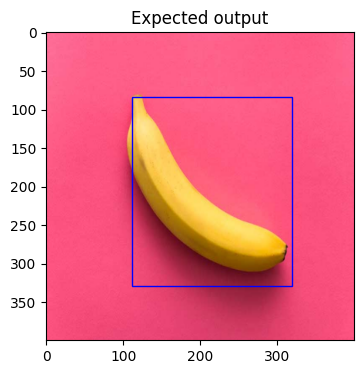

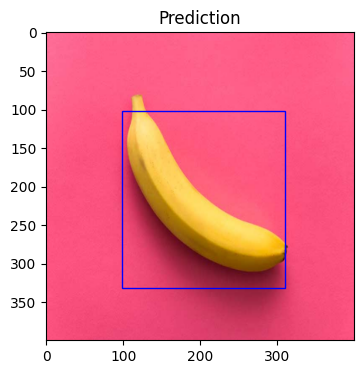

In [16]:
# Get random image.
img, target = test_dataset[np.random.randint(0, len(test_dataset))]

# Move image to device.
model.eval()

# Get prediction.
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Plot expected output.
plot_img_with_bbox(tensor_to_PIL_image(img), target, 'Expected output')

# Apply non-maximum suppression.
nms_prediction = apply_nms(prediction, threshold=0.01)

# Convert to CPU.
nms_prediction_cpu = {k: v.cpu() for k, v in nms_prediction.items()}

# Plot prediction.
plot_img_with_bbox(tensor_to_PIL_image(img), nms_prediction_cpu, 'Prediction')

<br><br><br><br><br>
## ================= Test calories prediction =================

## ================= Support classes =================

### Fruit class

In [12]:
class Fruit:
  def __init__(self):
    self.calories = {'apple': 52, 'orange': 47, 'banana': 89}
    self.width = {'apple': 7, 'orange': 7, 'banana': 3}
    self.density = {'apple': 0.7, 'orange': 1, 'banana': 1.1}

  def get_volume(self, fruit, area):
    volume = 0
    if fruit == 'apple':
      # Radio.
      r = math.sqrt(area / math.pi)

      # Volume.
      volume = (4/3) * math.pi * (r**3)
    elif fruit == 'orange':
      # Radio.
      r = math.sqrt(area / math.pi)

      # Volume.
      volume = (4/3) * math.pi * (r**3)
    elif fruit == 'banana':
      # Volume.
      volume = area * self.width[fruit]
    return volume

### Coin class

In [13]:
class Coin:
  def __init__(self):
    self.volume = 0.402
    self.area = 5.027

<br><br><br>
## ================= Functions =================

### Get prediction

In [14]:
def get_prediction(img):
  # Image copy.
  img_copy = img.copy()

  # Get shape.
  height, width, _ = img_copy.shape

  # BGR to RGB and data type changed.
  img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB).astype(np.float32)

  # Normalization.
  img_copy /= 255.0

  # Convert to tensor.
  img_copy = torch.as_tensor(img_copy, dtype=torch.float32)

  # Permute dimensions.
  img_copy = img_copy.permute(2, 0, 1)

  # Move image to device.
  model.eval()

  # Get prediction.
  with torch.no_grad():
      prediction = model([img_copy.to(device)])[0]

  # Apply non-maximum suppression.
  nms_prediction = apply_nms(prediction, threshold=0.01)

  # Only the biggest bounding boxes.
  for box_i in nms_prediction['boxes']:
    # Get width and height of the bbox.
    width_i, height_i = box_i[2]-box_i[0], box_i[3]-box_i[1]

    # Get area.
    area = width_i * height_i

    # If area is less than the 5% of the image area, remove it.
    if area <= 0.005 * height * width:
      # Get index.
      index = nms_prediction['boxes'].tolist().index(box_i.tolist())

      # Remove box.
      nms_prediction['boxes'] = torch.cat((nms_prediction['boxes'][:index],
                                          nms_prediction['boxes'][index+1:]))
      nms_prediction['scores'] = torch.cat((nms_prediction['scores'][:index],
                                            nms_prediction['scores'][index+1:]))
      nms_prediction['labels'] = torch.cat((nms_prediction['labels'][:index],
                                            nms_prediction['labels'][index+1:]))

  # Convert to CPU.
  nms_prediction_cpu = {k: v.cpu() for k, v in nms_prediction.items()}

  # # Plot prediction.
  # plot_img_with_bbox(tensor_to_PIL_image(img_copy), nms_prediction_cpu, 'Prediction')

  return img_copy, nms_prediction_cpu

### Get cropped images

In [15]:
def get_cropped_image(img, nms_prediction_cpu):
  # Image copy.
  img_copy = copy.deepcopy(img)

  # List of cut images.
  cropped_images = []

  # Crop image
  for i, box_i in enumerate(nms_prediction_cpu['boxes']):
    # Crop image.
    crop_img = img_copy[:, int(box_i[1]):int(box_i[3]), int(box_i[0]):int(box_i[2])]

    # Tensor to PIL image.
    crop_img = tensor_to_PIL_image(crop_img)

    # PIL image to numpy array.
    crop_img = np.array(crop_img)

    # Append image and label.
    cropped_images.append([crop_img, classes[nms_prediction_cpu['labels'][i]]])

    # # Show image.
    # plt.imshow(crop_img)
    # plt.show()

  return cropped_images

### Get area percentage

In [16]:
def get_area_percentage(cropped_images, original_img):
  # Shape of the original image.
  height, width, _ = original_img.shape

  # Variables to save data.
  coin = 0
  fruits = []

  for crop_img, label in cropped_images:
    # Shape.
    height_i, width_i, _ = crop_img.shape

    # Get percentage of the area in comparison with the original image.
    crop_img_percentage = (height_i * width_i) / (height * width)

    # Image copy.
    crop_img_copy = crop_img.copy()

    # Convert from RGB to GRAY.
    gray = cv2.cvtColor(crop_img_copy, cv2.COLOR_BGR2GRAY)

    # Get contours.
    _, thresh = cv2.threshold(gray, 170, 200, cv2.THRESH_BINARY_INV)

    # Get contours.
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Only keep the biggest contour, excluding the background.
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # Convert to numpy array.
    contours = np.array(contours)

    # # Draw contours.
    # cv2.drawContours(crop_img_copy, contours, -1, (0, 255, 0), 10)

    # Get area of the contour.
    contour_area = cv2.contourArea(contours)

    # Get percentage of the area.
    contour_percentage = contour_area / (height_i * width_i)

    # Get percentage of the area in comparison with the original image.
    contour_general_percentage = contour_percentage * crop_img_percentage

    if label == 'coin':
      # Append coin.
      coin = contour_general_percentage
    else:
    # Append fruits.
      fruits.append([label, contour_general_percentage])

    # print(label, crop_img_percentage, contour_general_percentage)

    # # Show image.
    # plt.imshow(crop_img_copy, cmap='gray')
    # plt.show()

  # print('\n\n\n\n\n\n\n\n')
  return coin, fruits

### Get calories

In [17]:
def get_calories(coin, fruits):
  # Calories per fruit.
  calories = []

  # For each fruit.
  for label, fruit_area_percentage in fruits:
    # Area of the fruit.
    fruit_area = (fruit_area_percentage * Coin().area) / coin

    # Volume of the fruit.
    fruit_volume = Fruit().get_volume(label, fruit_area)

    # Mass of the fruit.
    fruit_mass = fruit_volume * Fruit().density[label]

    # Calories of the fruit (per 100 grams).
    fruit_calories = (fruit_mass * Fruit().calories[label]) / 100

    # Append calories.
    calories.append(fruit_calories)

  return calories

<br><br><br>
## ================= Process =================

### Load data

In [18]:
# Test images directory.
test_images_dir = './datasets/calories_estimation/'

# Load images.
apples = [cv2.imread(os.path.join(test_images_dir + 'apples', f)) for f in os.listdir(test_images_dir + 'apples')]
bananas = [cv2.imread(os.path.join(test_images_dir + 'bananas', f)) for f in os.listdir(test_images_dir + 'bananas')]
oranges = [cv2.imread(os.path.join(test_images_dir + 'oranges', f)) for f in os.listdir(test_images_dir + 'oranges')]

In [19]:
# print(os.listdir(test_images_dir + 'apples'))
# print(os.listdir(test_images_dir + 'bananas'))
# print(os.listdir(test_images_dir + 'oranges'))

### Data size

In [20]:
print("Apple: " + str(len(apples)))
print("Banana: " + str(len(bananas)))
print("Orange: " + str(len(oranges)))

Apple: 50
Banana: 50
Orange: 50


### Get predictions about the images

In [21]:
apple_nms_predictions_cpu = []
banana_nms_predictions_cpu = []
orange_nms_predictions_cpu = []

In [22]:
for apple in apples[:6]:
  apple_nms_predictions_cpu.append( get_prediction(apple) )
for banana in bananas[:6]:
  banana_nms_predictions_cpu.append( get_prediction(banana) )
for orange in oranges[:6]:
  orange_nms_predictions_cpu.append( get_prediction(orange) )

In [ ]:
# for apple in apples[10:20]:
#   apple_nms_predictions_cpu.append( get_prediction(apple) )
# for banana in bananas[10:20]:
#   banana_nms_predictions_cpu.append( get_prediction(banana) )
# for orange in oranges[10:20]:
#   orange_nms_predictions_cpu.append( get_prediction(orange) )

In [ ]:
# for apple in apples[20:30]:
#   apple_nms_predictions_cpu.append( get_prediction(apple) )
# for banana in bananas[20:30]:
#   banana_nms_predictions_cpu.append( get_prediction(banana) )
# for orange in oranges[20:30]:
#   orange_nms_predictions_cpu.append( get_prediction(orange) )

In [ ]:
# for apple in apples[30:40]:
#   apple_nms_predictions_cpu.append( get_prediction(apple) )
# for banana in bananas[30:40]:
#   banana_nms_predictions_cpu.append( get_prediction(banana) )
# for orange in oranges[30:40]:
#   orange_nms_predictions_cpu.append( get_prediction(orange) )

In [ ]:
# for apple in apples[40:]:
#   apple_nms_predictions_cpu.append( get_prediction(apple) )
# for banana in bananas[40:]:
#   banana_nms_predictions_cpu.append( get_prediction(banana) )
# for orange in oranges[40:]:
#   orange_nms_predictions_cpu.append( get_prediction(orange) )

### Length predictions

In [23]:
print("Apple: " + str(len(apple_nms_predictions_cpu)))
print("Banana: " + str(len(banana_nms_predictions_cpu)))
print("Orange: " + str(len(orange_nms_predictions_cpu)))

Apple: 6
Banana: 6
Orange: 6


In [ ]:
# for i in orange_nms_predictions_cpu:
#   plt.imshow(i[0].permute(1, 2, 0))
#   plt.show()
#   print(i[1])

### Crop images inside bounding boxes

In [24]:
cropped_apple_imgs = []
cropped_banana_imgs = []
cropped_orange_imgs = []

for img, apple_nms_prediction_cpu in apple_nms_predictions_cpu:
  cropped_images = get_cropped_image(img, apple_nms_prediction_cpu)
  cropped_apple_imgs.append( cropped_images )

for img, banana_nms_prediction_cpu in banana_nms_predictions_cpu:
  cropped_images = get_cropped_image(img, banana_nms_prediction_cpu)
  cropped_banana_imgs.append( cropped_images )

for img, orange_nms_prediction_cpu in orange_nms_predictions_cpu:
  cropped_images = get_cropped_image(img, orange_nms_prediction_cpu)
  cropped_orange_imgs.append( cropped_images )

### Get area percentage of the contour

In [25]:
apple_area_percentage = {'coin': [], 'fruits': []}
banana_area_percentage = {'coin': [], 'fruits': []}
orange_area_percentage = {'coin': [], 'fruits': []}

for cropped_images, original_img in zip(cropped_apple_imgs, apples):
  coin_percentage, fruits_percentage = get_area_percentage(cropped_images, original_img)
  apple_area_percentage['coin'].append( coin_percentage )
  apple_area_percentage['fruits'].append( fruits_percentage )

for cropped_images, original_img in zip(cropped_banana_imgs, apples):
  coin_percentage, fruits_percentage = get_area_percentage(cropped_images, original_img)
  banana_area_percentage['coin'].append( coin_percentage )
  banana_area_percentage['fruits'].append( fruits_percentage )

for cropped_images, original_img in zip(cropped_orange_imgs, apples):
  coin_percentage, fruits_percentage = get_area_percentage(cropped_images, original_img)
  orange_area_percentage['coin'].append( coin_percentage )
  orange_area_percentage['fruits'].append( fruits_percentage )

### Get calories

In [26]:
apple_calories_record = []
banana_calories_record = []
orange_calories_record = []

for i in range(len(apple_area_percentage['coin'])):
  coin = apple_area_percentage['coin'][i]
  fruits = apple_area_percentage['fruits'][i]
  apple_calories_record += get_calories(coin, fruits)

for i in range(len(banana_area_percentage['coin'])):
  coin = banana_area_percentage['coin'][i]
  fruits = banana_area_percentage['fruits'][i]
  banana_calories_record += get_calories(coin, fruits)

for i in range(len(orange_area_percentage['coin'])):
  coin = orange_area_percentage['coin'][i]
  fruits = orange_area_percentage['fruits'][i]
  orange_calories_record += get_calories(coin, fruits)

<br><br><br>
## ================= Metrics =================

In [32]:
print(f"Apple Metrics\nMean: {np.mean(apple_calories_record)} - Median: {np.median(apple_calories_record)} - Std: {np.std(apple_calories_record)} - Max: {np.max(apple_calories_record)} - Min: {np.min(apple_calories_record)}\n\n\n")
print(f"Banana Metrics\nMean: {np.mean(banana_calories_record)} - Median: {np.median(banana_calories_record)}- Std: {np.std(banana_calories_record)} - Max: {np.max(banana_calories_record)} - Min: {np.min(banana_calories_record)}\n\n\n")
print(f"Orange Metrics\nMean: {np.mean(orange_calories_record)} - Median: {np.median(orange_calories_record)}- Std: {np.std(orange_calories_record)} - Max: {np.max(orange_calories_record)} - Min: {np.min(orange_calories_record)}\n\n\n")

Apple Metrics
Mean: 106.35651140980302 - Median: 105.94207490375106 - Std: 5.134364313357625 - Max: 116.49387962765914 - Min: 100.52178105500934



Banana Metrics
Mean: 170.74070647323006 - Median: 169.24043810811048- Std: 4.328570747138177 - Max: 178.61026074482427 - Min: 165.08608247016787



Orange Metrics
Mean: 302.5457764004056 - Median: 126.87796137991481- Std: 393.91756051719534 - Max: 1183.3632779296247 - Min: 123.11516153023827





<br><br><br>
## ================= Plots =================

In [33]:
labels =  ['Apple', 'Banana', 'Orange']

### Boxplot

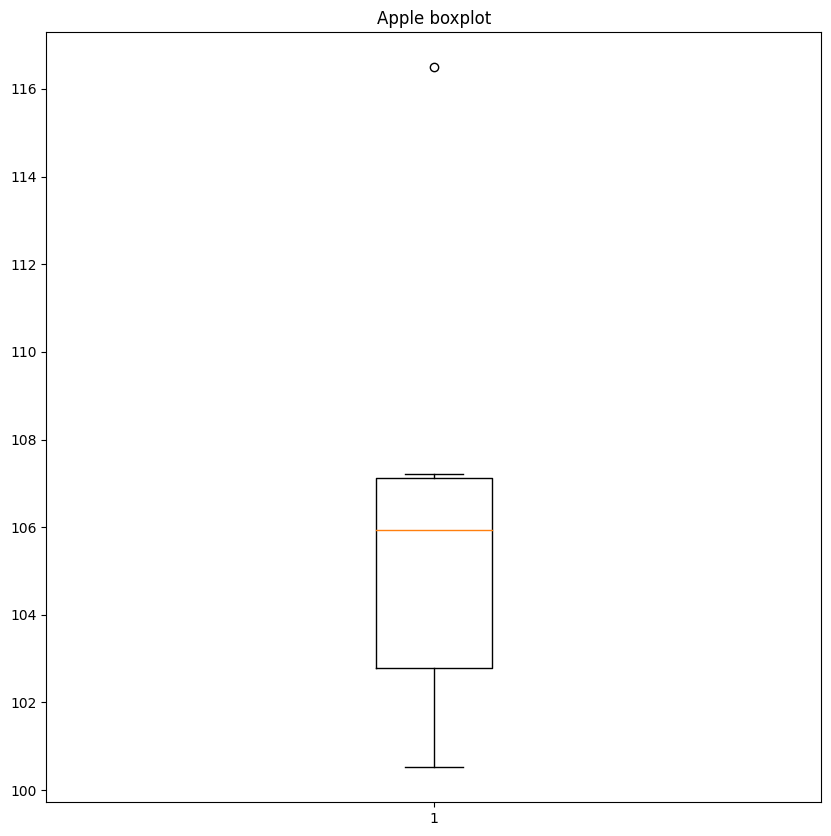

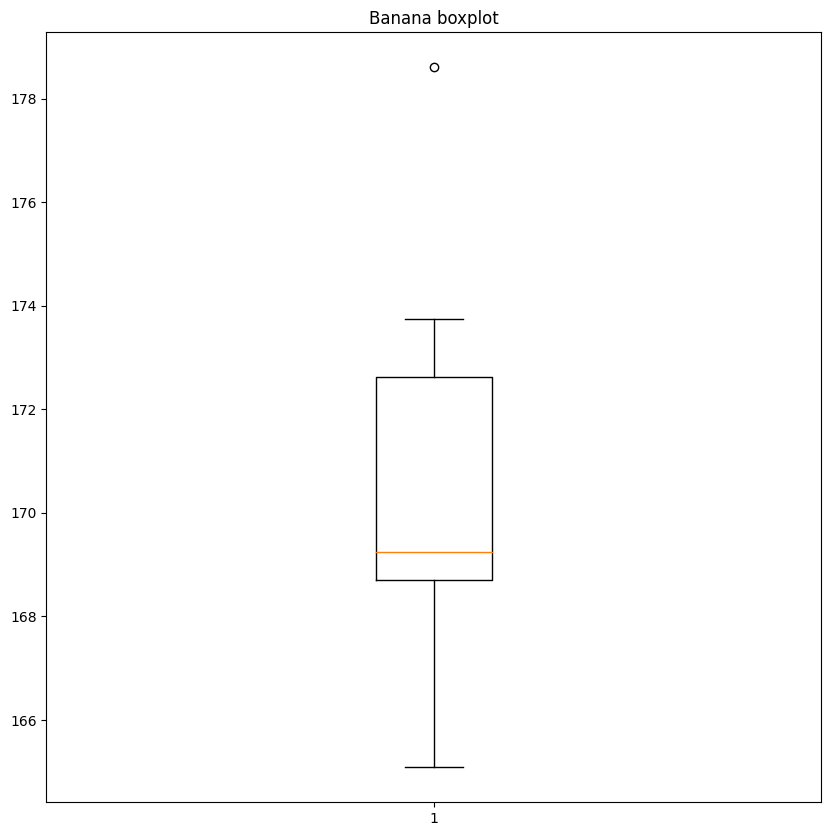

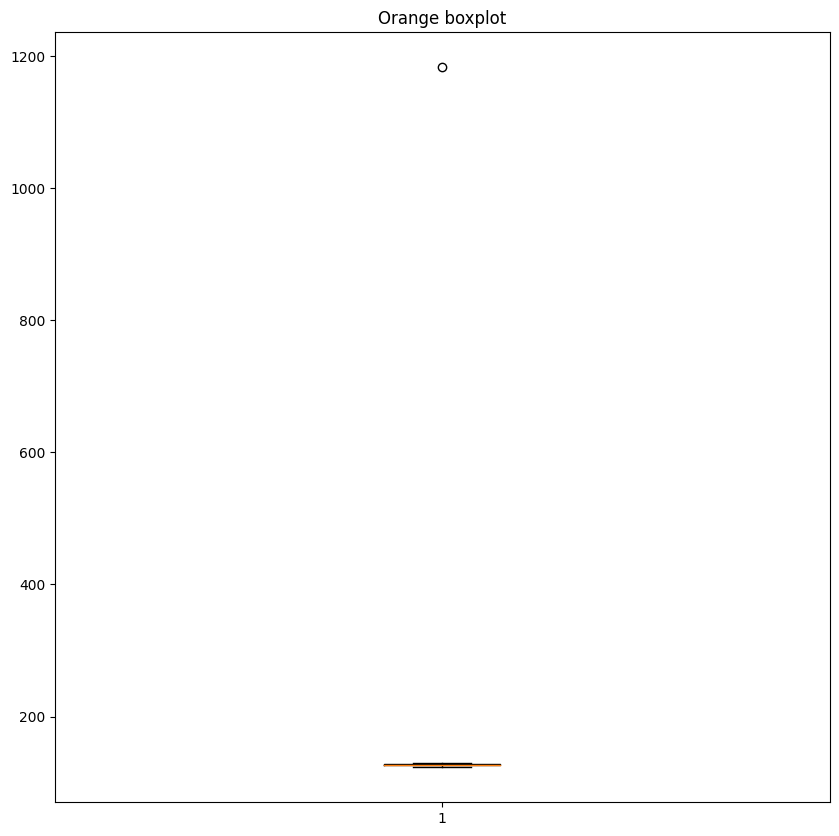

In [38]:
def plot_boxplot(record, name):
  plt.figure(figsize=(10, 10))
  plt.title(f"{name} boxplot")
  plt.boxplot(record)
  plt.show()

plot_boxplot(apple_calories_record, 'Apple')
plot_boxplot(banana_calories_record, 'Banana')
plot_boxplot(orange_calories_record, 'Orange')

### Line plot

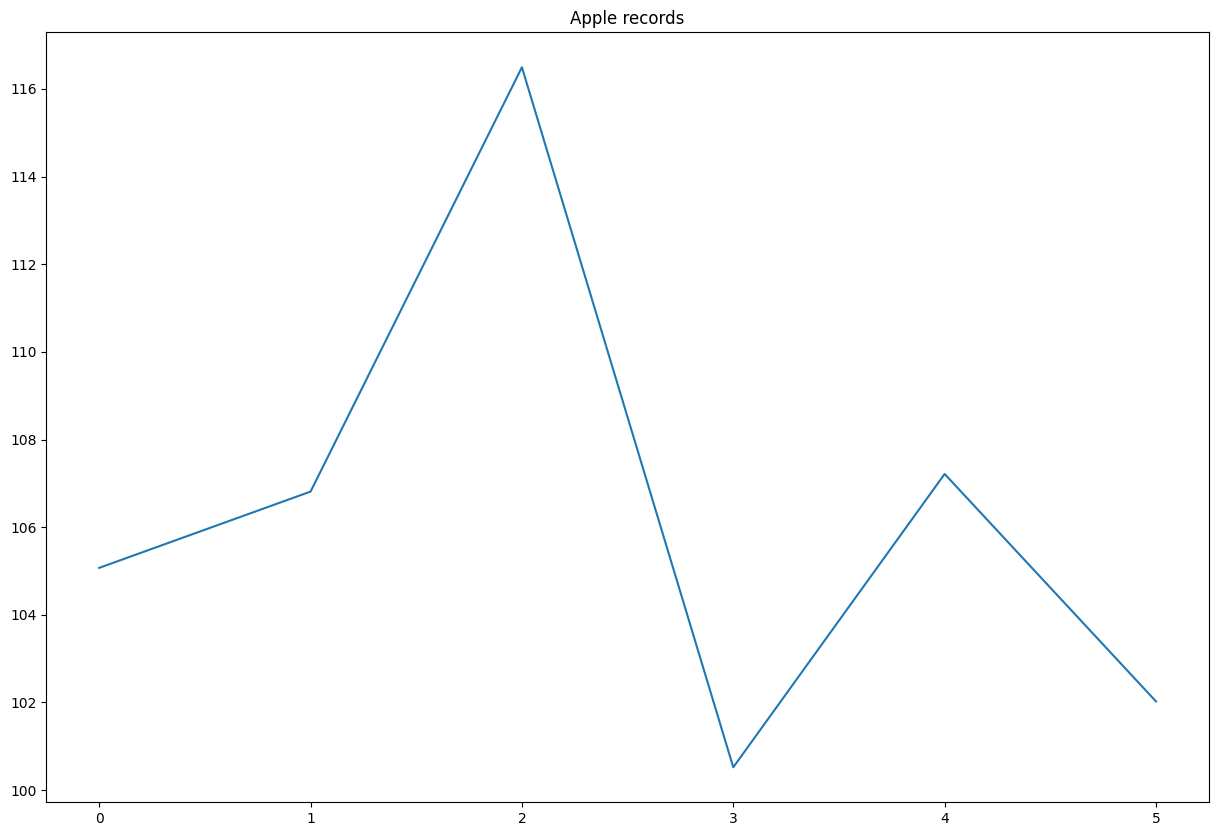

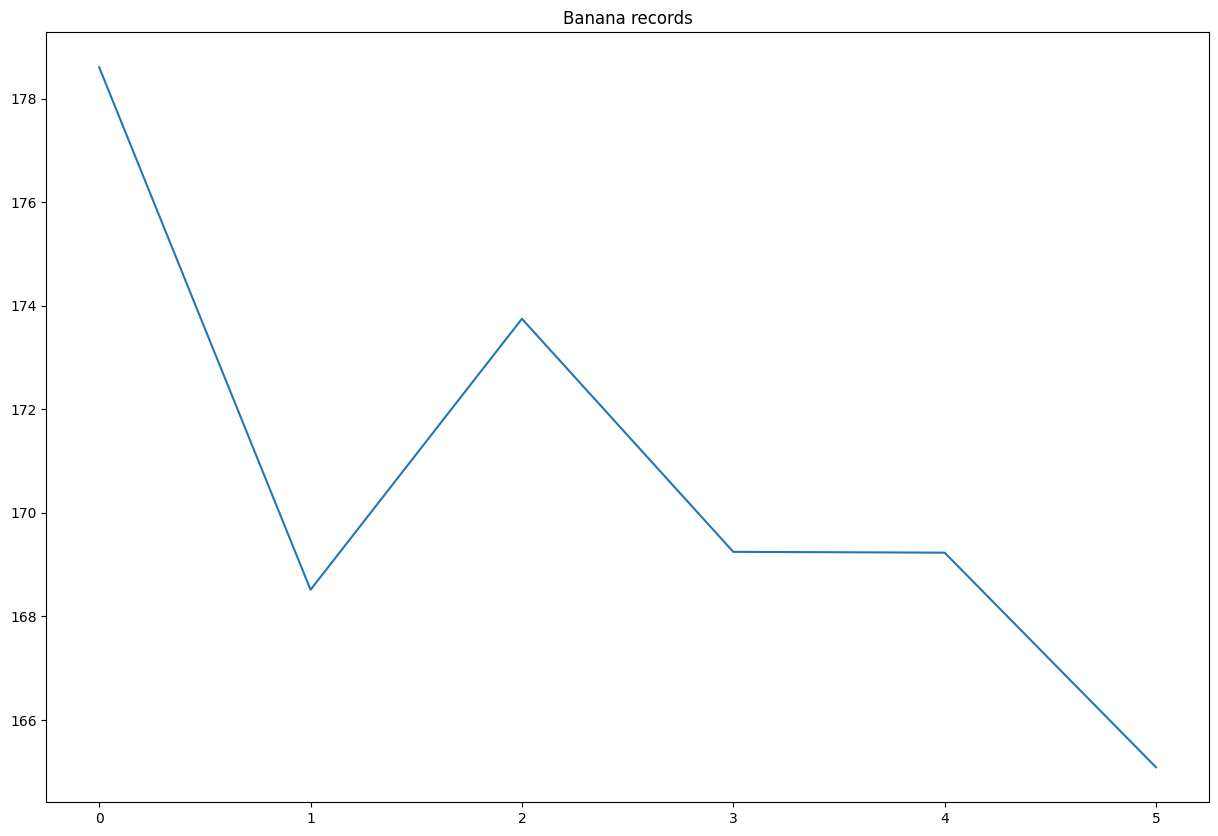

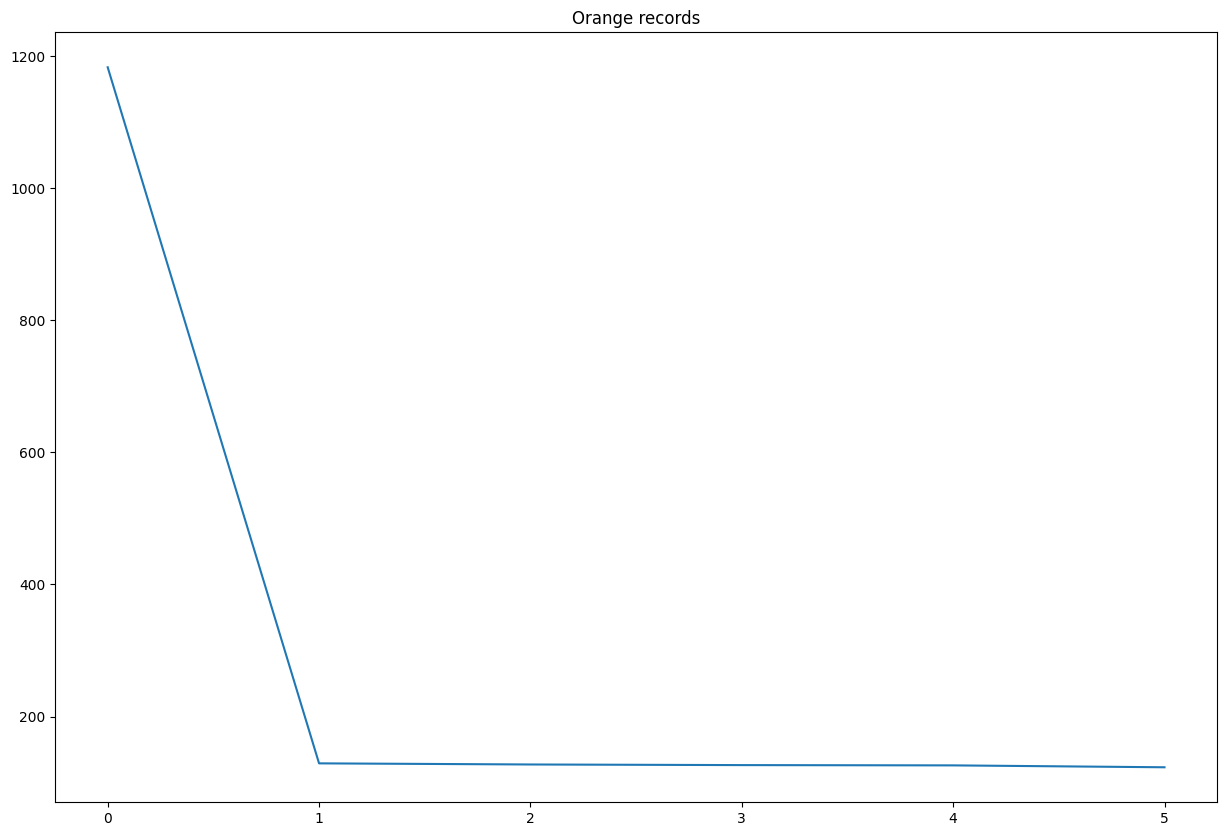

In [46]:
# Plot de linea para cada record
def plot_line(record, name):
    plt.figure(figsize=(15, 10))
    plt.plot(record)
    plt.title(f"{name} records")
    plt.show()

plot_line(apple_calories_record, 'Apple')
plot_line(banana_calories_record, 'Banana')
plot_line(orange_calories_record, 'Orange')